
# Fraud Detection
## Tasks

- Explore/Visualize the dataset
- Decide which features are important
- Perform Machine Learning
- Test the model on the testing set

<b>source dataset:</b> <https://www.kaggle.com/c/ieee-fraud-detection/data>

In [1]:
import pandas as pd
import sklearn as sk
import seaborn as sns
import numpy as np
import random
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Loading data

In [2]:
def reduce_mem_usage(df, verbose=True):
    """ 
    iterate through all the columns of a dataframe and 
    modify the data type to reduce memory usage.        
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
df_train_identity = pd.read_csv("train_identity.csv")
df_train_transaction = pd.read_csv("train_transaction.csv")

df_train_identity = reduce_mem_usage(df_train_identity)
df_train_transaction = reduce_mem_usage(df_train_transaction)

Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 542.35 Mb (69.4% reduction)


In [4]:
df_train_full = pd.merge(df_train_identity, df_train_transaction, on='TransactionID', how='left')
df_train_full = df_train_full.sample(frac=1).reset_index(drop=True)

# Data exploration

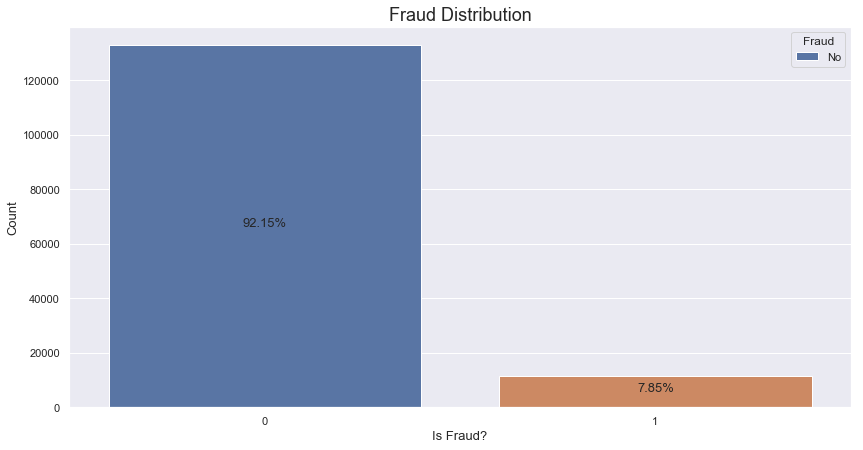

In [5]:
sns.set(style="darkgrid")
plt.figure(figsize=(14,7))
graph = sns.countplot(x = 'isFraud', data = df_train_full, orient='v')
graph.set_title("Fraud Distribution", fontsize = 18)
graph.set_xlabel("Is Fraud?", fontsize = 13)
graph.set_ylabel("Count", fontsize = 13)
plt.legend(title='Fraud', labels=['No', 'Yes'])

for bar in graph.patches:
    height = bar.get_height()
    graph.text(bar.get_x()+bar.get_width()/2., height/2.,
            '{:1.2f}%'.format(height/len(df_train_full) * 100),
            ha="center", fontsize=13) 

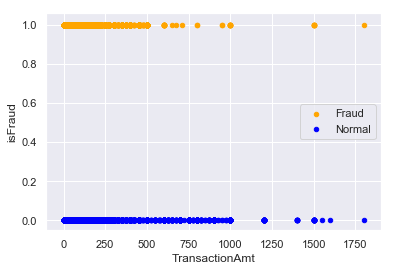

In [6]:
frauds = df_train_full.loc[df_train_full['isFraud']==1]
non_frauds = df_train_full.loc[df_train_full['isFraud']==0]

ax = frauds.plot.scatter(x='TransactionAmt', y='isFraud', color='Orange', label='Fraud')
non_frauds.plot.scatter(x='TransactionAmt', y='isFraud', color='Blue', label='Normal', ax=ax)
plt.show()

# Missing values

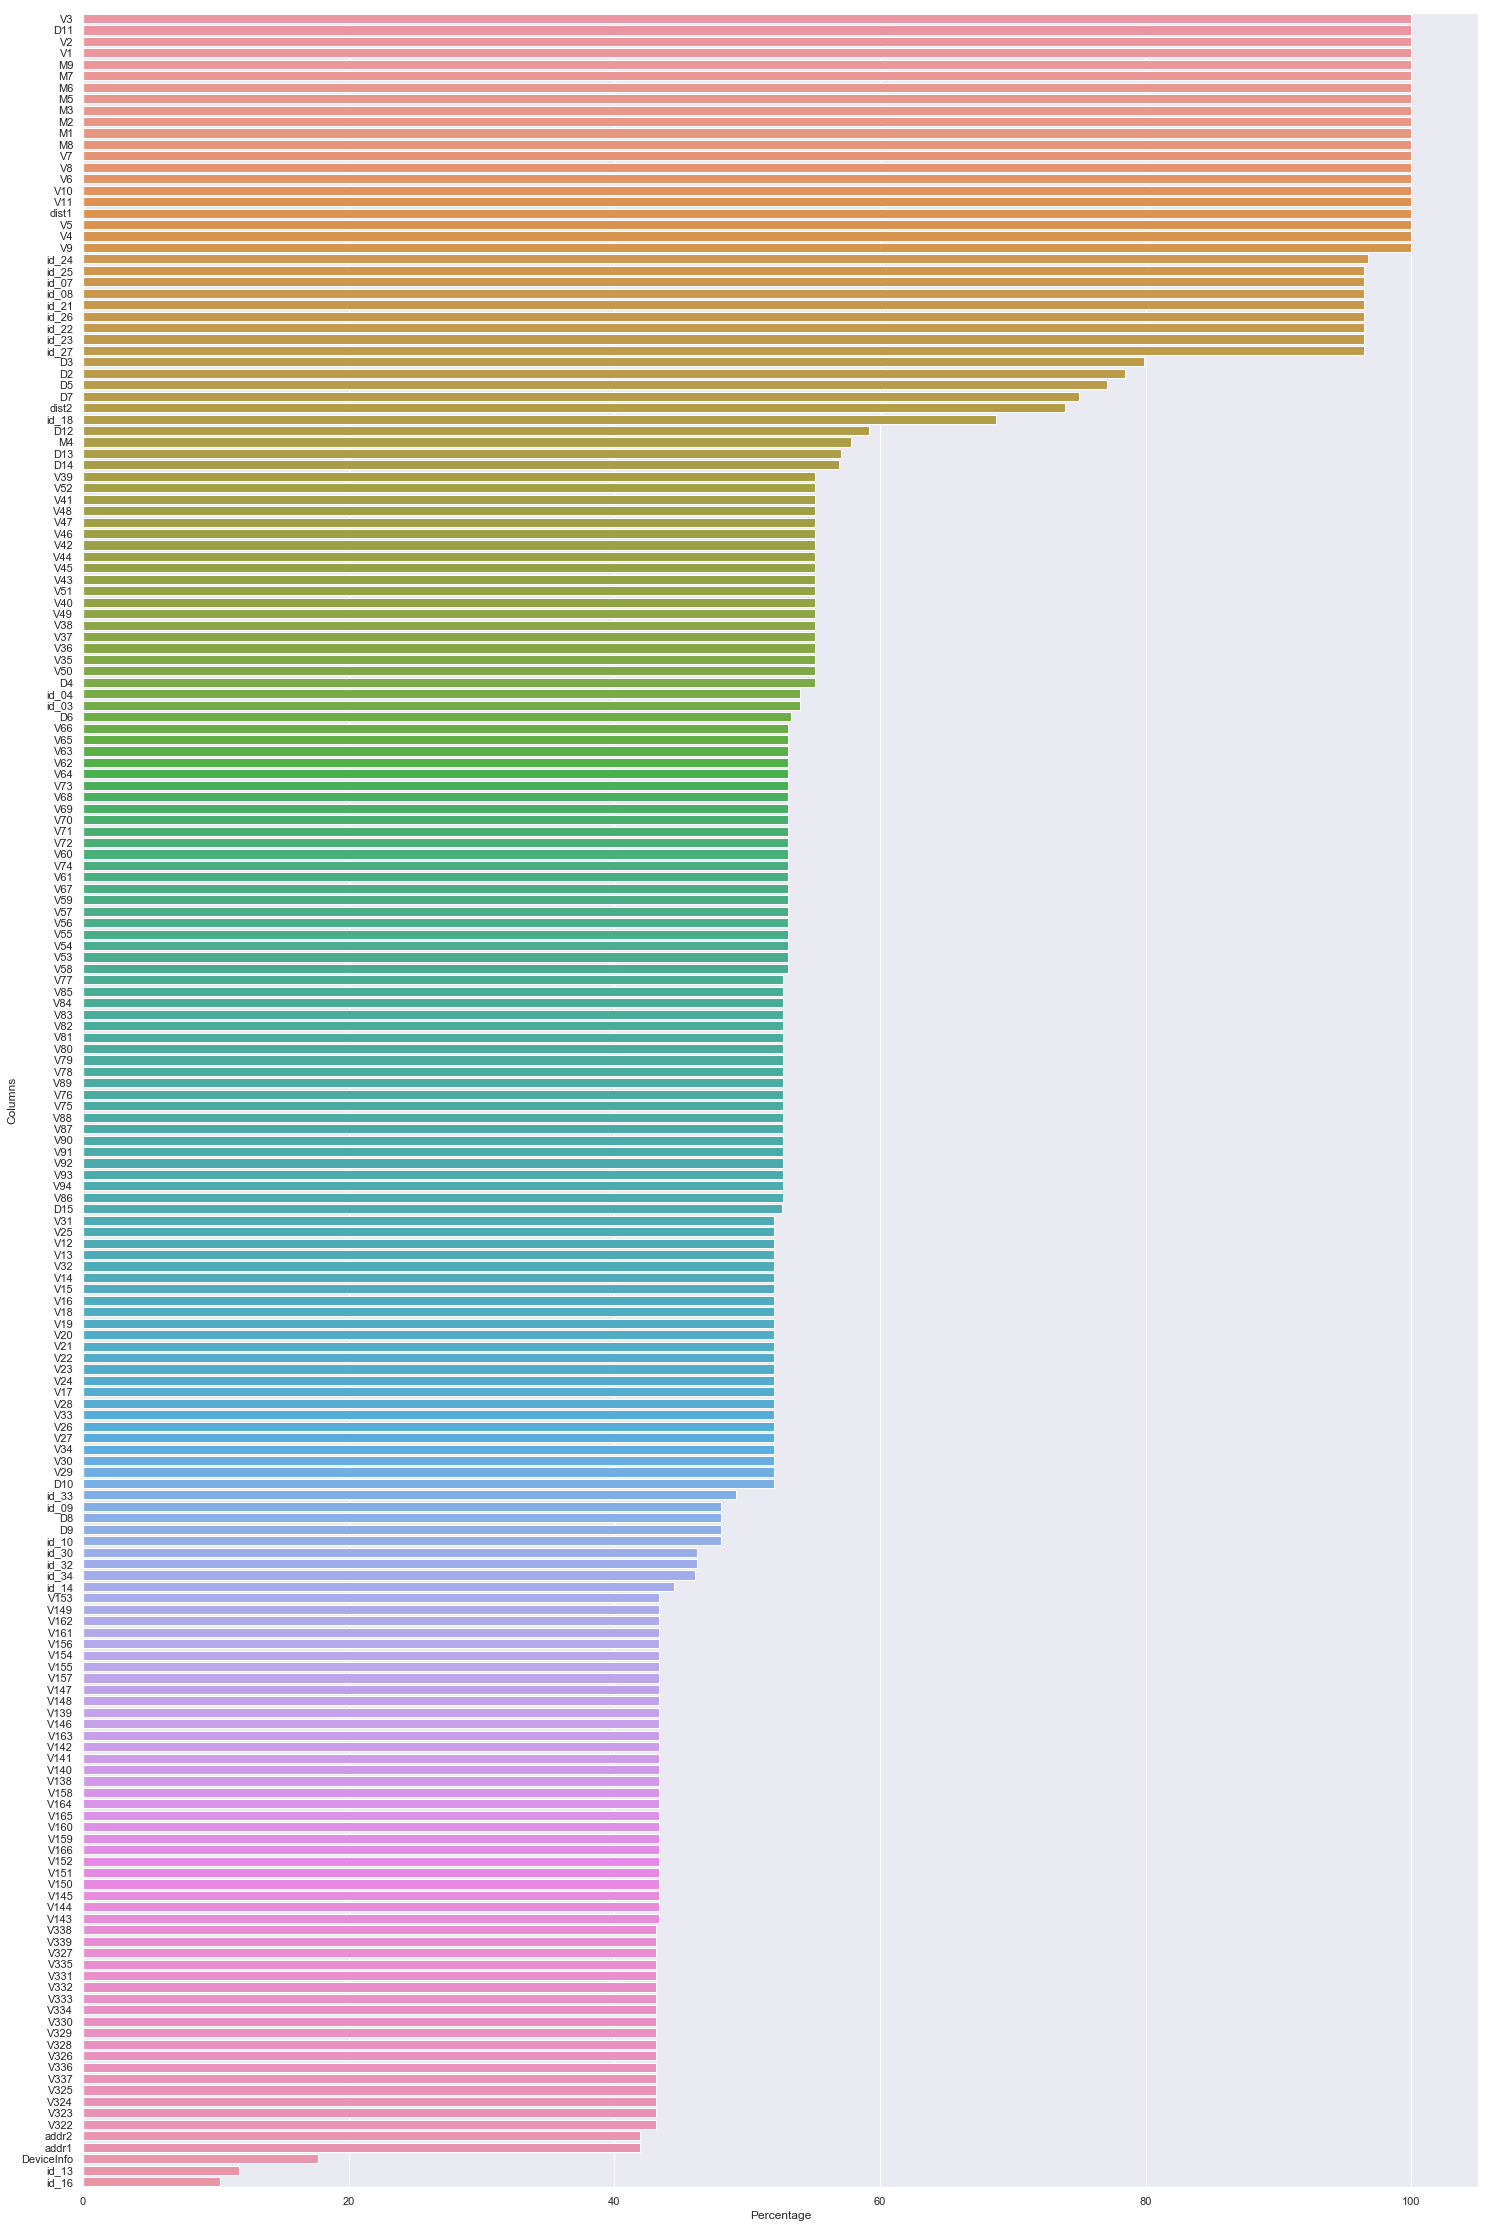

In [7]:
na_data = pd.isnull(df_train_full).sum().sort_values(ascending=False)
na_percentage = (na_data/len(df_train_full))*100.0
df_missing = pd.concat(objs = [na_data, na_percentage], keys = ['Records','Percentage'], axis = 1)
df_missing['Columns']=df_missing.index
df_missing = df_missing.reset_index(drop=True)

plt.figure(figsize=(25,40))
graph = sns.barplot(x = 'Percentage', y = 'Columns', data = df_missing.loc[df_missing['Percentage']>=10])

In [8]:
#droping most nuls columns
df_train_full=df_train_full[df_train_full.columns.intersection(df_missing.loc[df_missing['Percentage']<10]['Columns'])]
df_train_full=df_train_full.fillna(-999)
df_train_full.head()


,TransactionID,id_01,id_02,id_05,id_06,id_11,id_12,id_15,id_17,id_19,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,3081732,0.0,22329.0,2.0,0.0,100.0,NotFound,Found,166.0,100.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0
1,3177944,-5.0,64292.0,0.0,0.0,100.0,NotFound,New,166.0,542.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0
2,3393337,-10.0,144736.0,0.0,0.0,100.0,NotFound,Found,159.0,410.0,...,0.0,25.359375,25.359375,25.359375,0.0,46.0252,0.0,0.0,0.0,0.0
3,3018759,0.0,71431.0,1.0,-6.0,100.0,NotFound,New,166.0,621.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0
4,3200698,-5.0,103709.0,0.0,0.0,100.0,Found,Found,166.0,215.0,...,85.0,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0


# Repeated values

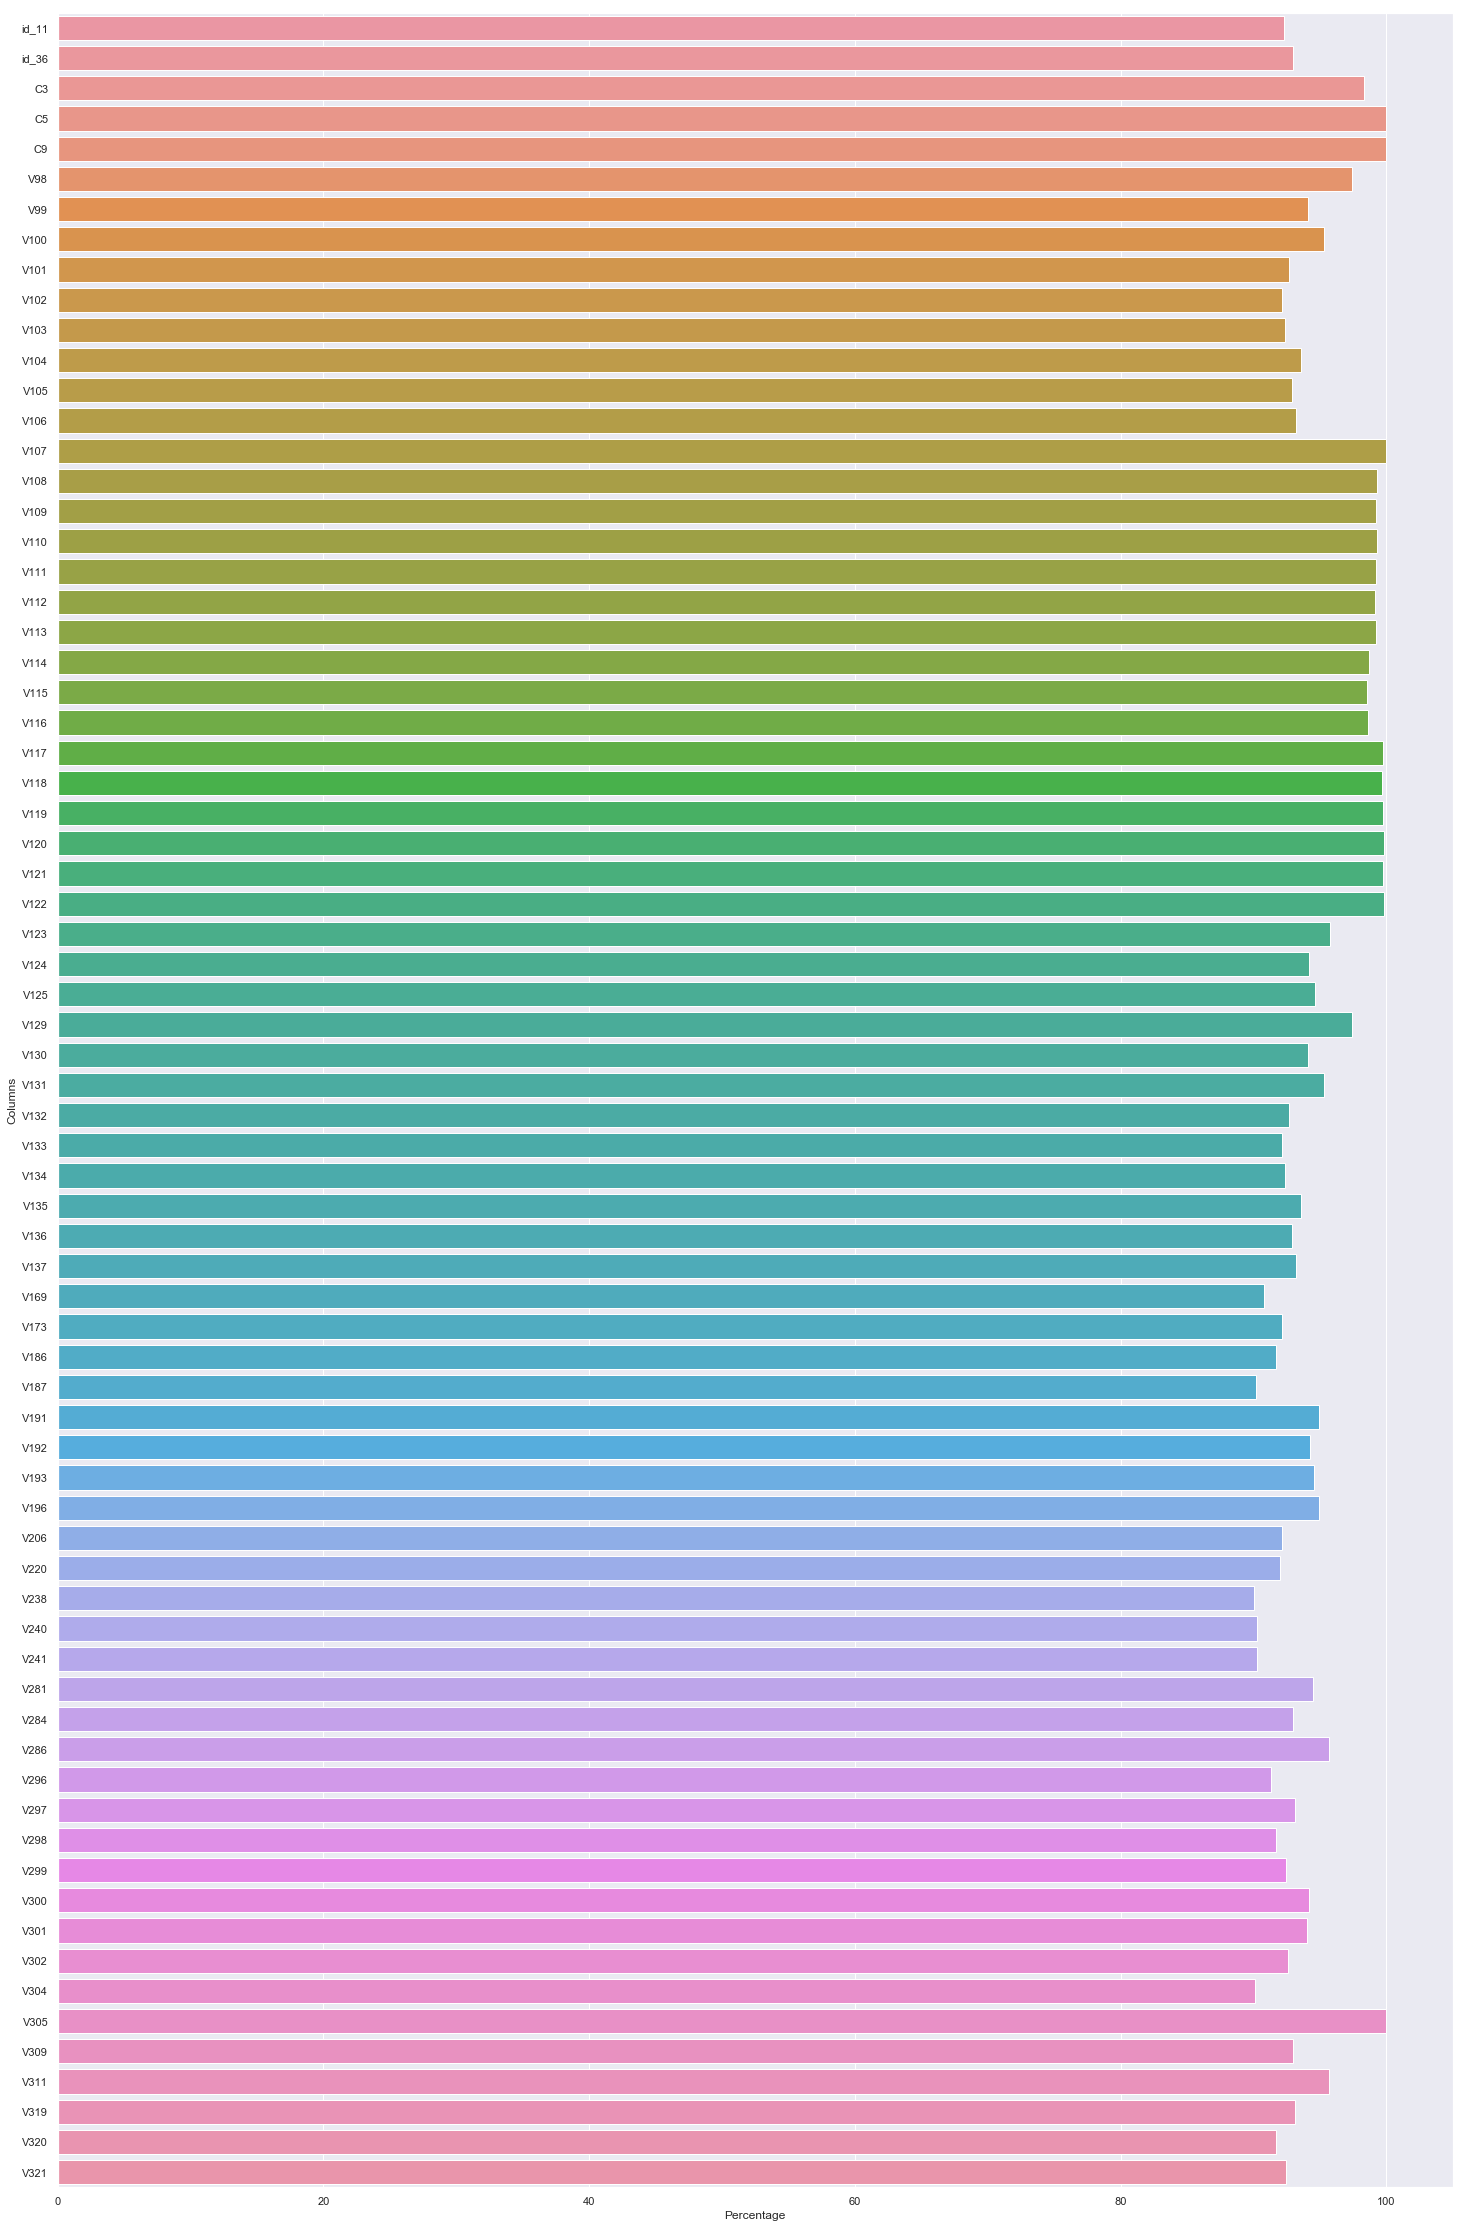

In [9]:
#select column with more than 90% repeated values
df = df_train_full.drop('isFraud', axis=1)

df_repeated_most = []
for col in df.columns:
    df_repeated_most.append({'Columns': col, 'Percentage': df_train_full[col].value_counts(dropna = False, normalize = True).values[0] * 100.0})

df_repeated_most = pd.DataFrame(df_repeated_most)    
   
plt.figure(figsize=(25,40))
graph = sns.barplot(x = 'Percentage', y = 'Columns', data = df_repeated_most.loc[df_repeated_most['Percentage']>=90])

In [10]:
#droping repeated columns
columns = df_repeated_most.loc[df_repeated_most['Percentage']>=90]['Columns']
df_train_full = df_train_full.drop(columns, axis=1)

In [11]:
df_train_full.head()

,TransactionID,id_01,id_02,id_05,id_06,id_12,id_15,id_17,id_19,id_20,...,V307,V308,V310,V312,V313,V314,V315,V316,V317,V318
0,3081732,0.0,22329.0,2.0,0.0,NotFound,Found,166.0,100.0,489.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0000,0.0
1,3177944,-5.0,64292.0,0.0,0.0,NotFound,New,166.0,542.0,484.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0000,0.0
2,3393337,-10.0,144736.0,0.0,0.0,NotFound,Found,159.0,410.0,300.0,...,71.380402,0.0,25.359375,0.0,25.359375,25.359375,25.359375,0.0,46.0252,0.0
3,3018759,0.0,71431.0,1.0,-6.0,NotFound,New,166.0,621.0,107.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0000,0.0
4,3200698,-5.0,103709.0,0.0,0.0,Found,Found,166.0,215.0,533.0,...,435.000000,85.0,435.000000,85.0,0.000000,0.000000,0.000000,0.0,0.0000,0.0


# Encoding categorical 


In [12]:
X = df_train_full.drop(['isFraud', 'TransactionID'], axis=1)
y = df_train_full['isFraud']

for col in X.columns:
    if X[col].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X[col].values))
        X[col] = lbl.transform(list(X[col].values))
        
cat_cols = [col for col in df_train_full.columns if df_train_full[col].dtype in ['object']]
X[cat_cols].describe().transpose()        

,count,mean,std,min,25%,50%,75%,max
id_12,144233.0,0.852960,0.354147,0.0,1.0,1.0,1.0,1.0
id_15,144233.0,1.566126,0.672416,0.0,1.0,2.0,2.0,3.0
id_28,144233.0,1.426331,0.538247,0.0,1.0,1.0,2.0,2.0
id_29,144233.0,1.435386,0.539409,0.0,1.0,1.0,2.0,2.0
id_31,144233.0,69.179924,28.115893,0.0,48.0,57.0,99.0,130.0
id_35,144233.0,1.516983,0.542911,0.0,1.0,2.0,2.0,2.0
id_37,144233.0,1.743270,0.485654,0.0,2.0,2.0,2.0,2.0
id_38,144233.0,1.442444,0.540118,0.0,1.0,1.0,2.0,2.0
DeviceType,144233.0,1.362067,0.527675,0.0,1.0,1.0,2.0,2.0
ProductCD,144233.0,0.989780,1.006334,0.0,0.0,1.0,2.0,3.0


# Modeling

In [13]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.35)

lr = linear_model.LogisticRegression(solver="liblinear", C = 1e5, random_state=42)
lr.fit(X_train, y_train)
print("Score:", lr.score(X_test, y_test))

Score: 0.9190800681431005


# Testing

In [15]:
y_predicted = np.array(lr.predict(X_test))
y_predicted

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)